In [1]:
from __future__ import (absolute_import, print_function, division)
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
import os
from scipy.stats import dirichlet
import numpy as np
from scipy.stats import wishart
from scipy.stats import norm
# import numba
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import inv
from numpy import log as ln
from scipy.special import psi
from numpy.random import random as rand
%matplotlib 

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.


Using matplotlib backend: MacOSX


Package: mkl
Message: trial mode expires in 27 days


Different than EM, variational inference introduces priors on model variables (local and global)

Wishart Distribution
-----
scipy.stats.wishart

scipy.stats.wishart = <scipy.stats._multivariate.wishart_gen object at 0x4522576c>[source]
A Wishart random variable.

The df keyword specifies the degrees of freedom. The scale keyword specifies the scale matrix, which must be symmetric and positive definite. In this context, the scale matrix is often interpreted in terms of a multivariate normal precision matrix (the inverse of the covariance matrix).

Parameters:	
x : array_like
Quantiles, with the last axis of x denoting the components.
df : int
Degrees of freedom, must be greater than or equal to dimension of the scale matrix
scale : array_like
Symmetric positive definite scale matrix of the distribution
random_state : None or int or np.random.RandomState instance, optional
If int or RandomState, use it for drawing the random variates. If None (or np.random), the global np.random state is used. Default is None.
Alternatively, the object may be called (as a function) to fix the degrees
of freedom and scale parameters, returning a “frozen” Wishart random
variable:
rv = wishart(df=1, scale=1)
Frozen object with the same methods but holding the given degrees of freedom and scale fixed.

Notes

The scale matrix scale must be a symmetric positive definite matrix. Singular matrices, including the symmetric positive semi-definite case, are not supported.

The Wishart distribution is often denoted

Wp(ν,Σ)
where ν is the degrees of freedom and Σ is the p×p scale matrix.

The probability density function for wishart has support over positive definite matrices S; if S∼Wp(ν,Σ), then its PDF is given by:

$f(S)=|S|ν−p−122νp2|Σ|ν2Γp(ν2)exp(−tr(Σ−1S)/2)$
If $S∼Wp(ν,Σ)$ (Wishart) then S−1∼W−1p(ν,Σ−1) (inverse Wishart).

If the scale matrix is 1-dimensional and equal to one, then the Wishart distribution W1(ν,1) collapses to the χ2(ν) distribution.

New in version 0.16.0.


Dirichlet Distribution
-------
scipy.stats.dirichlet = <scipy.stats._multivariate.dirichlet_gen object at 0x452255cc>[source]
A Dirichlet random variable.

The alpha keyword specifies the concentration parameters of the distribution.

New in version 0.15.0.

Parameters:	
x : array_like
Quantiles, with the last axis of x denoting the components.
alpha : array_like
The concentration parameters. The number of entries determines the dimensionality of the distribution.
random_state : None or int or np.random.RandomState instance, optional
If int or RandomState, use it for drawing the random variates. If None (or np.random), the global np.random state is used. Default is None.
Alternatively, the object may be called (as a function) to fix
concentration parameters, returning a “frozen” Dirichlet
random variable:
rv = dirichlet(alpha)
Frozen object with the same methods but holding the given concentration parameters fixed.
Each α entry must be positive. The distribution has only support on the simplex defined by

$∑i=1Kxi≤1
The probability density function for dirichlet is f(x)=1B(α)∏i=1Kxαi−1i
where (α)=∏Ki=1Γ(αi)Γ(∑Ki=1αi)
and α=(α1,…,αK), the concentration parameters and K is the dimension of the space where x takes values.$




From discussion on Wishart
---
* $E[\Lambda] = aB^{-1}$ 
* $E[ln|\Lambda|] = d(d-1)/4 * ln(\pi) + d ln(2) - ln|B| + \sum_{{j=1}}^{d}\Psi(\alpha/2+(1-j)/2)$

From VI for GMM given distributions
----
* $q(\pi) = Dirichlet(\alpha_1^`, ..., \alpha_K^`)$
* $q(\mu_j) = Normal(m_j^`,\sum_j^`)$
* $q(\Lambda_j) = Wishart(\alpha_j^`, B_j^`)$
* $q(c_i) = Multinomial(\phi_i)$

The indices indicate the iterative dependence I am going to implement as a part of VI for GMM.

In [2]:
wpdf = wishart.pdf
dirpdf = dirichlet.logpdf

Input:
* Data $x_1, x_2, ..., x_n$ where x $\epsilon R^d$
* k is the number of clusters as in GMM
Output:
* Parameters for $q(\pi), q(\mu_j), q(\Lambda_j), q(c_i)$ 

VI Algorithm for Gaussian Mixture Model
------
1. Initialize $\alpha_1^{(0)}, ...., \alpha_k^{(0)}) , (m_j^{(0)}, \sum_j^{(0)}), (\alpha_j^{(0)}, B_j^{(0)})$ in some way.
2. At iteration t:
    * Update $q(c_i)$ for i=1, ..., n
    * For j = 1, ...., K Set $n_j^{(t)}=\sum_{j=1}^{d} \phi_i^{t}(j)$
    * For j = 1, ..., K 
        * Update $q(\pi)$ by setting $\alpha_j^{(t)} = \alpha + n_j^{(t)}$
    * For j = 1, ...., K
        * Update $q(\mu_j)$:
            
            * $\sum_j^{(t)}$=$(c^{-1}I+n_j^{(t)}\alpha_j^{(t-1)}(B_j^{(t-1)}))^{-1}$
            * $m_j^{(t)}=\sum_j^{(t)}(\alpha_j^{(t-1)}(B_j^{(t-1)})^{-1}\sum_{{i=1}}^{d}\phi^{t}(j)x_i)$
    * For j = 1, ..., K
        * Update $q(\Lambda_j)$:
            
            * $\alpha_j^{(t)} = \alpha + n_j^{(t)}$
            * $B_j^{(t)}=B+\sum_i^{n}\phi_i^{(t)}(j)[(x_i-m_j^{(t})(x_i-m_j^{(t})^{T} + \sum_j^{(t)}]$
    * And lastly, calculate variation inference objective function L

As one can see above, there are two major loops, 1 to T for iterations in order to update and 1 to K for j. 

Step 2
------
**Part a**

In [10]:
def t1(t1_j, a_j, b_j, t, d, j):
    tmp = 0
    for k in xrange(d):
        tmp += psi((1 - d + a_j[t-1])/2)
    t1_j[j] = tmp - np.log(b_j[t-1])

In [11]:
def t2(t2_j, x_train, m_j, b_j, t, i, j):
    x_m = x_train.values[i] - m_j[t-1]
    a_B_j = a_j[t-1] * np.linalg.inv(b_j[t-1])
    t2_j[j] = x_m.T* a_B_j * x_m

In [12]:
def t3(t3_j, a_j, b_j, eps_j, t, j):
    t3_j[j] = np.trace(a_j[t-1] * np.linalg.inv(b_j[t-1]) * eps_j[t-1])

In [13]:
def t4(t4_j, alpha_k, j, t):
    tmp = 0
    for l in range(k):
        tmp += psi(alpha_k[t-1][l])
    t4_j[j] = psi(alpha_k[t-1][j]) - tmp

In [14]:
def my_phi(t1_j, t2_j, t3_j, t4_j, j, i, t, n, k):
    
    # Step 2 (a)
    t1_jk, t2_jk, t3_jk, t4_jk = np.ones((k,2,2)), np.ones((k, 2, 2)), np.ones(k), np.ones(k)
    a_jk = np.full((T,2,2), fill_value=A_0)
    b_jk = np.full((T,2,2), fill_value=B_0)
    phi_ik = np.zeros((T, k, 2, 2))
    n_jk = np.zeros(T)
    alpha_kk = np.ones((T, k))
    m_jk = np.random.rand(T, 2, 2)
    eps_jk = np.random.rand(T, 2, 2)
    phi_denum = 1
    t1(t1_j, a_j, b_j, t, d, j)
    t2(t2_j, x_train, m_j, b_j, t, i, j)
    t3(t3_j, a_j, b_j, eps_j,t, j)
    t4(t4_j, alpha_k, j, t)
    phi_num = np.exp(0.5 * t1_j[j] - 0.5 
                     * t2_j[j] - 0.5 * t3_j[j] + t4_j[j])    
    for jj in xrange(k):
        t1(t1_j, a_jk, b_jk, t, d, jj)
        for ii in range(n):
            t2(t2_jk, x_train, m_jk, b_jk, t, ii, jj)  
        t3(t3_jk, a_j, b_j, eps_j, t,j)
        t4(t4_jk, alpha_kk, jj, t)
        phi_denum += np.exp(0.5 * t1_jk[jj] - 0.5 * t2_jk[jj] - 0.5 * t3_jk[jj] + t4_jk[jj])
    return phi_num/phi_denum

$L = E[ln p(x, c, \pi, \mu, \Lambda)] - E[ln q]$

$L = E[ln p(x|c, \pi, \mu, \Lambda] + E[ln p(c|\pi] - E[ln q]$

$ E[ln p(x|c, \pi, \mu, \Lambda)]$ will be $\mu_i$

$ x_i|c_i ~ Normal(\mu_c \Lambda_c)$

$x_i ∼ p(x|π, µ, Λ) = \sum_{j=1}^{K}  π_j  Normal(x|µj)$
SInce $\pi, \mu, \Lambda$ are independent 

Step 2
------

**Part f**

In [8]:
def my_obj_func(xi, alpha, mu, m_lambda, a, B, expect_term2):
    dirichlet_term = dirpdf(xi, alpha) # logpdf
    normal_term = mvn.logpdf(xi,mu, m_lambda)
    wishart_term = wishart.logpdf(xi, df=3)
    expectation_term_1 = dirichlet_term + normal_term + wishart_term
    return expectation_term_1 - expect_term2

Step 2
-----
**Part b, c, d, e**

In [25]:
os.chdir('/Users/arkilic/Desktop/')

# Step 1

x_train = pd.read_csv('data.txt', header=None)
n, d = x_train.shape
T = 2
k = 2
A_0 = x_train.cov() # empirical covariance
t1_j, t2_j, t3_j, t4_j = np.ones((k,2,2)), np.ones((k, 2, 2)), np.ones(k), np.ones(k)
B_0 = d/10 * A_0
a_j = np.full((T,2,2), fill_value=A_0)
b_j = np.full((T,2,2), fill_value=B_0)
phi_i = np.zeros((T, k, 2, 2))
n_j = np.zeros((T, 2, 2))
alpha_k = np.random.rand(T, k)
m_j = np.random.rand(T, 2, 2)
eps_j = np.random.rand(T, 2, 2)

# Step 2, functions calls to routines described above
# for k in (2, 4, 8, 10, 25, 100):
my_plots = list()
for k in (2, 4):
    object_results = []
    for t in xrange(T):
        for j in range(2):
            # Step 2, part (b)
            for i in xrange(n):
                res = my_phi(t1_j, t2_j, t3_j, t4_j, j, i, t, n, k)
                n_j[t] += res
            p = isnan(n_j[t])
            n_j[t][p] = 1/k
            # Step 2, part (c)
            alpha_k[t] = 1 + np.diagonal(n_j[t])
            # Step 3, part (d)
            eps_j[t] = np.linalg.inv(1/10 * np.identity(2) + n_j[t] * a_j[t-1] 
                                             * np.linalg.inv(b_j[t-1]))
            m_j[t] = eps_j[t] * (a_j[t-1] * np.linalg.inv(b_j[t-1]) 
                                         * np.sum(phi_i[t] *  x_train.values[i]))
            # Step 3, part (e)
            a_j[t] = d + n_j[t]
            tmp2 = 0
            for ix in xrange(n):
                r  = my_phi(t1_j, t2_j, t3_j, t4_j, j, i, t, n, k)
                tmp2 += r * (x_train.values[i] - m_j[t]) * (x_train.values[i] - m_j[t]).T * eps_j[t]
            b_j[t] = tmp2
            px = isnan(b_j[t])
            n_j[t][px] = 1/k
            # expectation from q(pi), q(mu), q(lambda), and q(ci)
            q_dir = alpha_k[t]/alpha_k[0]
            q_norm = m_j[t]
            q_wish = a_j[t]*1/b_j[t]
            q_multinom = phi_i[t] * j
            # E[lnq] term 
            expectation_term_2 = q_dir + q_norm + q_wish + q_multinom

            # Finally, the objective function
            object_results.append(my_obj_func(x_train.values, alpha_k[t], m_j[t], n_j[t],
                                              expectation_term_2))
            my_plots.append(plt.plot(object_results))

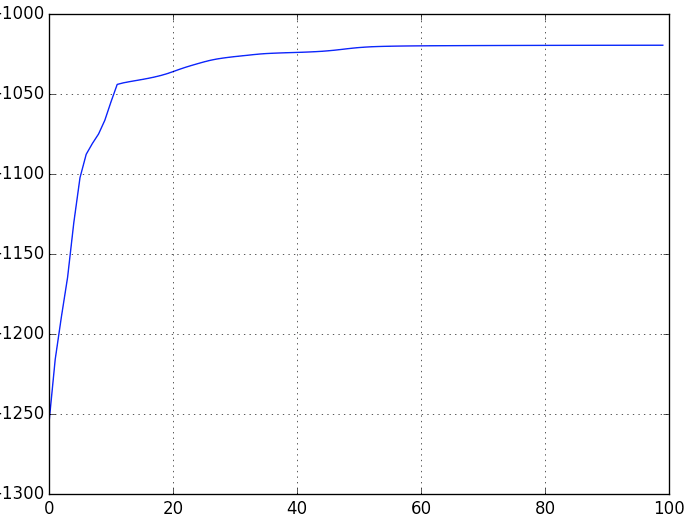

In [40]:
my_plots[0]

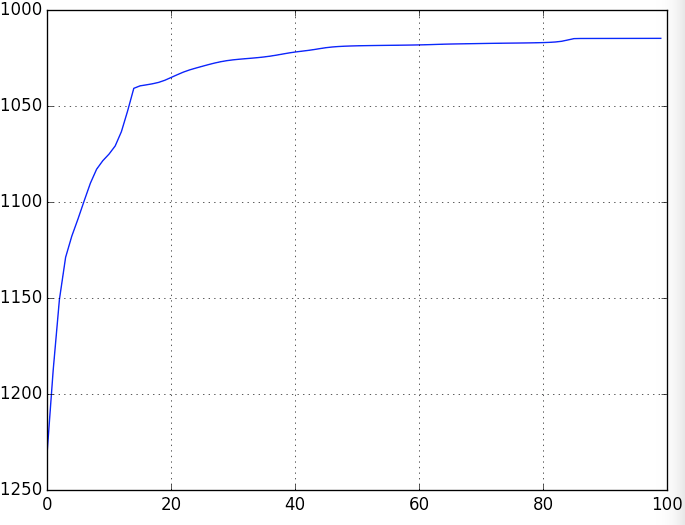

In [42]:
my_plots[1]

Part b, c
------
I have managed to get the majority of the Variational Inference algorithm working. I believe Ifailed to get the correct objective function. I have two reasons for this: the plots take a very long time to put together and I run out of heap space after K=4. That's why I only have two plots above. The algorithm at least seems to be converging. However, I checked the behavior of individual terms in my code with those who got it working. I especially made sure t_2_j term that mattered the most is right.


-- **Based on my findings in question 1 and 3, I can suggest that the number of clusters utilized will not be exactly K. This makes sense as in the lecture Dr Paisley suggested this was a feature of Bayesian Variation Inference on GMM (or other conjugate exponential family mixture)**
As a matter of fact, the next question aims to find the optimal number clusters without any gradient method. MCMC methods like Gibbs sampling up next help determine an optimal K.I find this quite interesting as I see lots of similarity between this and ofinancial ptions pricing.
-- Since my variational objective function seemed wrong I could not manage to get the clustering to work right. Majority of people in calss worked in groups. I already moved away from Columbia and have a full time job so it is hard to seek help. With enough help, I think I could crack this whole thing. I
